In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import plotly.express as px
import xgboost

#import pmdarima
#import arch
import math

#!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
#yf.pdr_override()


import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import ks_2samp

def retornos(vetor):
    ret = np.full(vetor.shape[0]-1, np.nan)
    for t in range(1,vetor.shape[0]):
        ret[t-1]=math.log(vetor[t])-math.log(vetor[t-1])
    return(ret)

def volatilidade(k,p,vetor):
    vol = np.full(vetor.shape[0], np.nan)
    for t in range(k,vetor.shape[0]):
        vol[t]=((sum((vetor[(t-k):t])**p))/k)**(1/p)
    return(vol)

%matplotlib inline

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


Pegando os dados

In [ ]:
#df = web.get_data_yahoo('PETR4.SA')
def eqm(real,ajust):
    ret = sum((real-ajust)**2)/np.shape(real)[0]
    ret = ret[0]**(1/2)
    return(ret)


#df
acoes = ['PETR4.SA','PETR3.SA','MGLU3.SA', '^BVSP', 'FLRY3.SA', 'QUAL3.SA', 'ITSA4.SA', 'WEGE3.SA', 'ABEV3.SA','AMER3.SA',
         'BEEF3.SA']
df_acao = web.get_data_yahoo(acoes, start = '2020-01-01', end = '2024-01-01')
df_var = web.get_data_yahoo(acoes, start = '2020-01-01', end = '2024-01-01')

#btc['Close'].plot(figsize = (22, 8))
#plt.title('BTC em U$')

df_acao['Close']['ITSA4.SA'].plot(color='blue',figsize=(22,8))
plt.title('Série de Preços: ITSA4.SA')
plt.xlabel('Data')
plt.ylabel('Preço de fechamento')
plt.legend()
#df_acao['Close']['MGLU3.SA'].plot(color='blue',figsize=(22,8))
#df_acao['Close']['^BVSP'].plot(color='blue',figsize=(22,8))

df_valores = df_acao['Close']['ITSA4.SA']


#plt.plot(preco_real_train2, color = 'red', label = 'Valores reais')
#plt.plot(ajustados_train2, color = 'blue', label = 'Ajustados')


In [ ]:
df_valores = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/ABEV3.SA_df_Valores.csv')
df_valores = df_valores['ABEV3.SA']
df_valores.head()

,ABEV3.SA
0,19.200001
1,18.930000
2,19.020000
3,19.059999
4,18.969999


# Random Forest - Volatilidade

Mounted at /content/drive


In [ ]:

df_prc = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/ABEV3.SA_Volatilidade - 5dep.csv')

df_prc = df_prc.iloc[:,1:]
df_prc = df_prc.dropna()
base_total = df_prc
print(base_total.head())



         x1        x2        x3        x4        x5         y
0  0.010561  0.003668  0.003662  0.006535  0.006197  0.012165
1  0.003668  0.003662  0.006535  0.006197  0.012165  0.012553
2  0.003662  0.006535  0.006197  0.012165  0.012553  0.013334
3  0.006535  0.006197  0.012165  0.012553  0.013334  0.012901
4  0.006197  0.012165  0.012553  0.013334  0.012901  0.002265


In [ ]:
max = np.amax(base_total)
min = np.amin(base_total)
base_treinamento_normalizada = (base_total-min)/(max-min)
base_treinamento_normalizada = base_treinamento_normalizada*1000
print(base_treinamento_normalizada.head())
print(np.amax(base_treinamento_normalizada))
print(np.amin(base_treinamento_normalizada))


          x1         x2         x3         x4         x5          y
0  73.778257  23.636117  23.589199  44.494499  42.032160  85.445278
1  23.636117  23.589199  44.494499  42.032160  85.445278  88.269728
2  23.589199  44.494499  42.032160  85.445278  88.269728  93.950290
3  44.494499  42.032160  85.445278  88.269728  93.950290  90.800992
4  42.032160  85.445278  88.269728  93.950290  90.800992  13.430075
1000.0
0.0


In [ ]:
# Tirando a v. resposta da base de treinamento
# df.drop(columns='cat')
X = base_treinamento_normalizada.drop(columns=["y"
#                      ,"cat"
                    ],axis = 1).copy()
y = base_treinamento_normalizada["y"].copy()

# Tirando ID da base de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X_train.shape

(787, 5)

613    0.019194
451    0.006398
731    0.034769
436    0.002039
275    0.005337
Name: y, dtype: float64

In [ ]:
# Treinar uma Random Forest com 5 árvores
#del(clf)
clf = RandomForestRegressor(max_depth=100, random_state=5, n_estimators=1000)
#n_estimators --> Número de árvores
clf.fit(X_train,y_train)
len(clf)

1000

<Axes: >

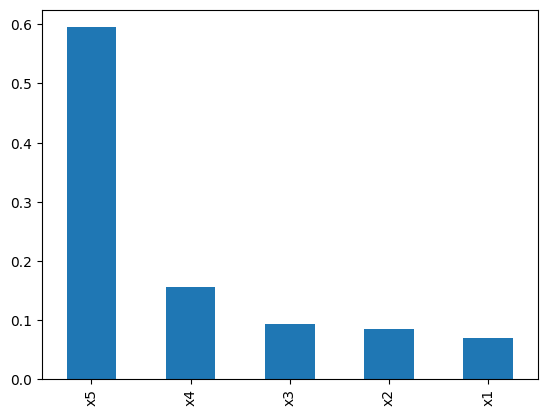

In [ ]:
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot.bar()

In [ ]:
# MSE
y_ajustado = clf.predict(X_train)
mse_clf1 = mean_squared_error(y_train, y_ajustado)
r2_clf1 = r2_score(y_train, y_ajustado)

y_pred = clf.predict(X_test)
mse_clf = mean_squared_error(y_test, y_pred)
r2_clf = r2_score(y_test, y_pred)

#print('Acurácia: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
#      .format(acc*100, auc*100, gini*100))

print(mse_clf1)
print(r2_clf1)
#print('MSE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf))
print('Treino = MSE: {0:.4f} \R-Squared: {1:.2f}%' .format(mse_clf1, r2_clf1))
print(" ")

print(mse_clf)
print(r2_clf)
#print('MSE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf))
print('Teste = MSE: {0:.4f} \R-Squared: {1:.2f}%' .format(mse_clf, r2_clf))



1.1544989317244713e-05
0.9323099738345777
Treino = MSE: 0.0000 \R-Squared: 0.93%
 
6.87165066717144e-05
0.5535567215997257
Teste = MSE: 0.0001 \R-Squared: 0.55%


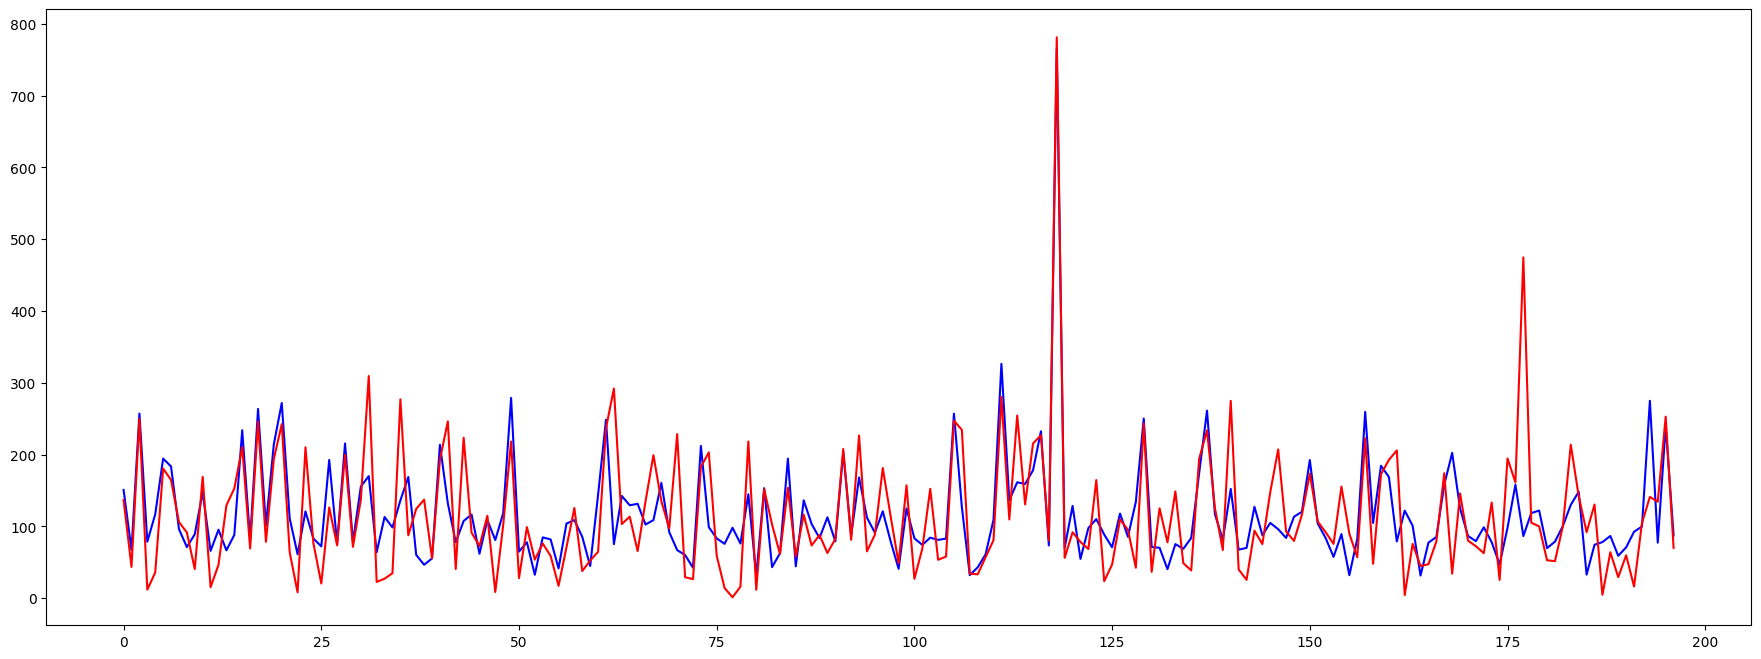

In [ ]:
#plt.plot(np.array(y_test), color = 'red', label = 'Real')
#plt.plot(ajustados_teste2_min, color = 'red', label = 'Mínimo')
#plt.plot(y_pred, color = 'blue', label = 'Previsto')

#y_test.plot(color='red',figsize=(22,8))

plt.figure(figsize=(22, 8))

plt.plot(y_pred, color = 'blue', label = 'Previsto',)
plt.plot(range(y_test.shape[0]),y_test, color = 'red', label = 'Real')


# Random Forest - Valores

In [ ]:
df_prc = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/ABEV3.SA_Valores - 5dep.csv')
df_vol = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/DesvioPadrao_ABEV.csv')

df_prc = df_prc.iloc[:,1:]
df_prc = df_prc.dropna()
base_total = df_prc
base_total.columns = ['1 dia anterior','2 dia anterior','3 dia anterior','4 dia anterior','5 dia anterior',"y"]
print(base_total.head())
print(df_vol.head())


   1 dia anterior  2 dia anterior  3 dia anterior  4 dia anterior  \
0       19.200001       18.930000       19.020000       19.059999   
1       18.930000       19.020000       19.059999       18.969999   
2       19.020000       19.059999       18.969999       18.820000   
3       19.059999       18.969999       18.820000       18.889999   
4       18.969999       18.820000       18.889999       19.209999   

   5 dia anterior          y  
0       18.969999  18.820000  
1       18.820000  18.889999  
2       18.889999  19.209999  
3       19.209999  19.100000  
4       19.100000  18.760000  
          x
0  0.020257
1  0.019487
2  0.018227
3  0.017194
4  0.016386


In [ ]:
max = np.amax(base_total)
min = np.amin(base_total)
base_treinamento_normalizada = (base_total-min)/(max-min)
base_treinamento_normalizada = base_treinamento_normalizada*100+1
print(base_treinamento_normalizada.head())
print(np.amax(base_treinamento_normalizada))
print(np.amin(base_treinamento_normalizada))


   1 dia anterior  2 dia anterior  3 dia anterior  4 dia anterior  \
0       96.332560       93.182030       94.232207       94.698940   
1       93.182030       94.232207       94.698940       93.648763   
2       94.232207       94.698940       93.648763       91.898476   
3       94.698940       93.648763       91.898476       92.715275   
4       93.648763       91.898476       92.715275       96.449227   

   5 dia anterior          y  
0       93.648763  91.898476  
1       91.898476  92.715275  
2       92.715275  96.449227  
3       96.449227  95.165695  
4       95.165695  91.198365  
101.0
1.0


In [ ]:
# Tirando a v. resposta da base de treinamento
# df.drop(columns='cat')
X = base_treinamento_normalizada.drop(columns=["y"
#                      ,"cat"
                    ],axis = 1).copy()
y = base_treinamento_normalizada["y"].copy()

# Tirando ID da base de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Treinar uma Random Forest com 5 árvores
#del(clf)
clf = RandomForestRegressor(max_depth=100, random_state=5, n_estimators=1000)
#n_estimators --> Número de árvores
clf.fit(X_train,y_train)
len(clf)

1000

<Axes: >

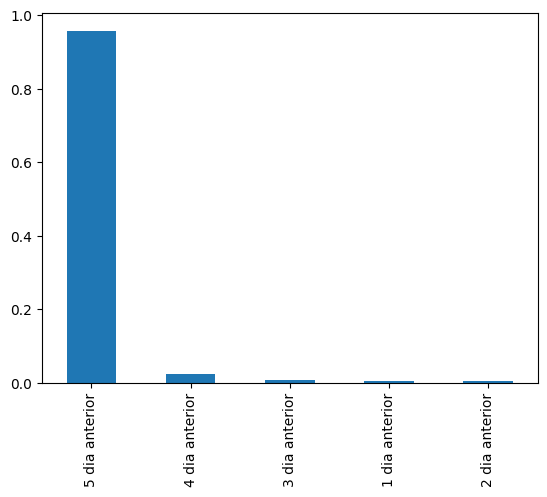

In [ ]:
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot.bar()

In [ ]:
# MSE
y_ajustado = clf.predict(X_train)
mse_clf1 = mean_absolute_percentage_error(y_train, y_ajustado)
r2_clf1 = r2_score(y_train, y_ajustado)

y_pred = clf.predict(X_test)
mse_clf = mean_absolute_percentage_error(y_test, y_pred)
r2_clf = r2_score(y_test, y_pred)

#print('Acurácia: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
#      .format(acc*100, auc*100, gini*100))

print(mse_clf1)
print(r2_clf1)
#print('MSE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf))
print('Treino = MSE: {0:.2f}% \R-Squared: {1:.0f}%' .format(mse_clf1*100, r2_clf1*100))
print(" ")

print(mse_clf)
print(r2_clf)
#print('MSE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf))
print('Teste = MSE: {0:.2f}% \R-Squared: {1:.0f}%' .format(mse_clf*100, r2_clf*100))



0.04033163753063371
0.994566364096608
Treino = MSE: 4.03% \R-Squared: 99%
 
0.10570832910983699
0.9539006055695243
Teste = MSE: 10.57% \R-Squared: 95%


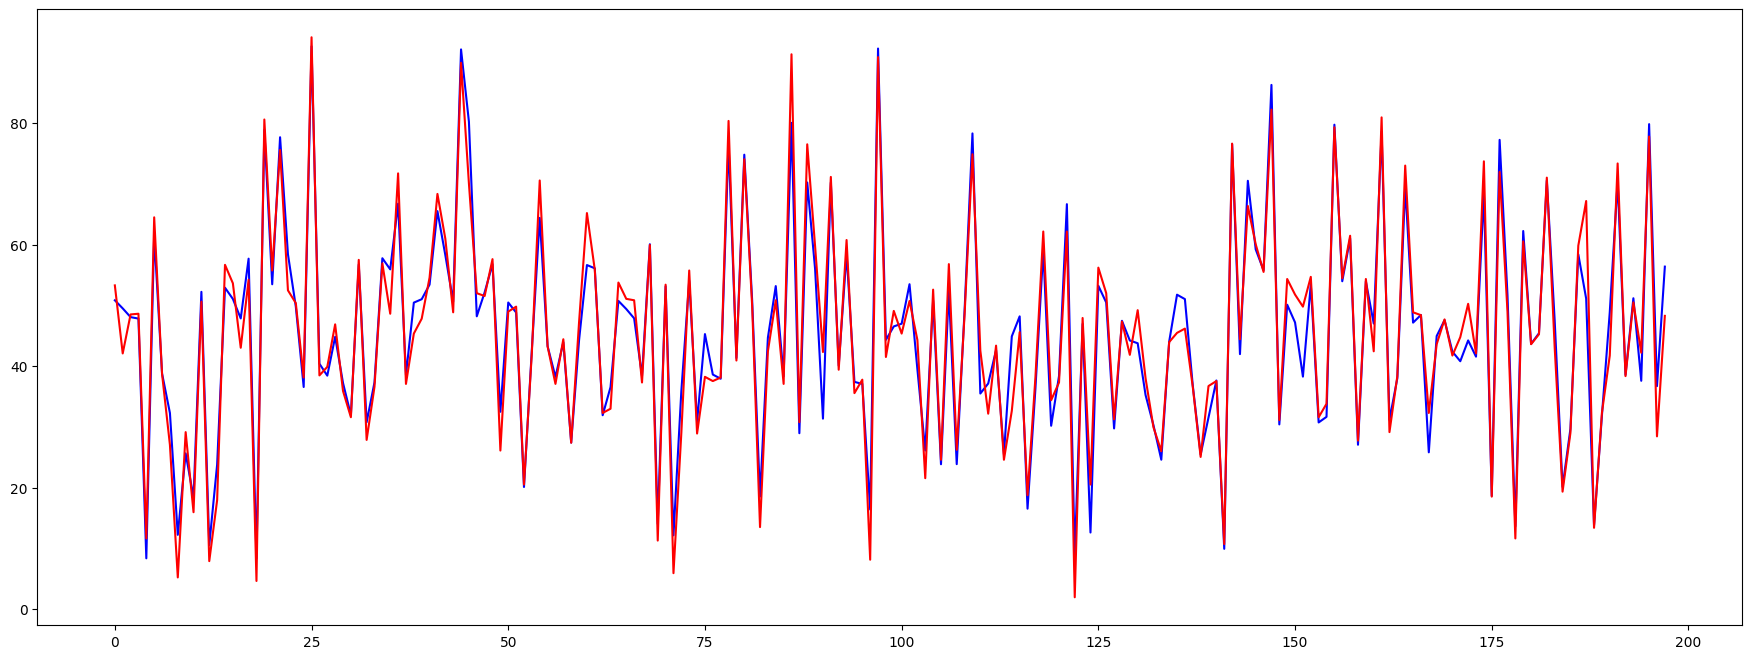

In [ ]:
#plt.plot(np.array(y_test), color = 'red', label = 'Real')
#plt.plot(ajustados_teste2_min, color = 'red', label = 'Mínimo')
#plt.plot(y_pred, color = 'blue', label = 'Previsto')

#y_test.plot(color='red',figsize=(22,8))

plt.figure(figsize=(22, 8))

plt.plot(y_pred, color = 'blue', label = 'Previsto',)
plt.plot(range(y_test.shape[0]),y_test, color = 'red', label = 'Real')


In [ ]:

#ret = retornos(df_valores)

#max = np.amax(df_valores)
#min = np.amin(df_valores)
#valores_normalizado = (df_valores-min)/(max-min)
#valores_normalizado = valores_normalizado*100+1
#print(valores_normalizado.head())
#print(np.amax(valores_normalizado))
#print(np.amin(valores_normalizado))
#print(valores_normalizado.shape)

max = np.amax(base_total)
min = np.amin(base_total)
ret_real = retornos(df_valores)
#ret_real = (((ret_real-1)/100)*(max-min))+min
vol_real = volatilidade(k=6,p=2,vetor=ret_real)
#X_real = (((X-1)/100)*(max-min))+min
y_ajustado_total = clf.predict((((base_total.iloc[:,0:5]-min)/(max-min))*100)+1)
print(y_ajustado_total.shape)

y_ajustado_total = (((y_ajustado_total-1)/100)*(max-min))+min
ret_ajustado = retornos(y_ajustado_total)
vol_ajustado = volatilidade(k=6,p=2,vetor=ret_ajustado)


(987,)


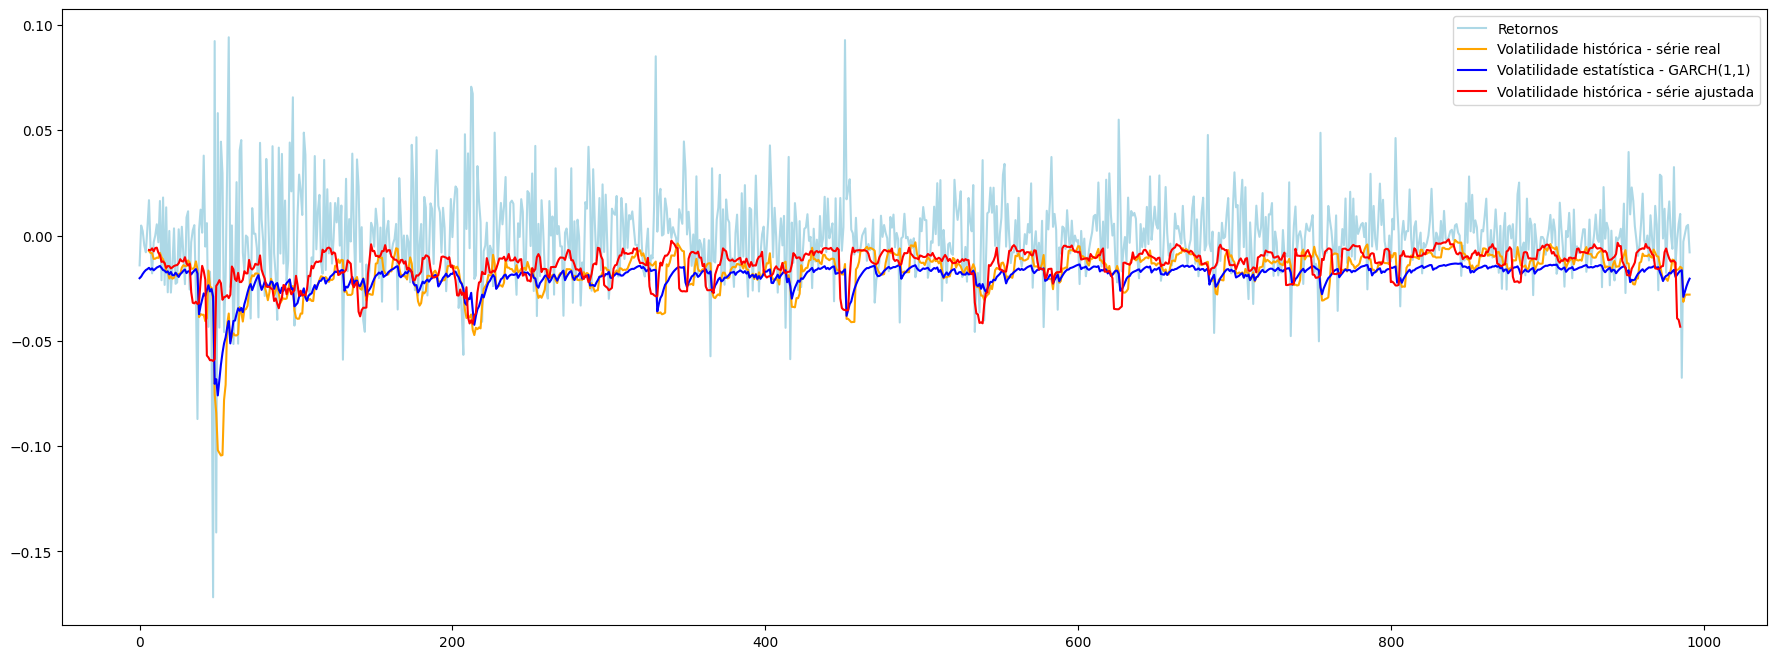

In [ ]:

plt.figure(figsize=(22, 8))

plt.plot(ret_real, color = 'lightblue', label = 'Retornos')
plt.plot(-vol_real, color = 'orange', label = 'Volatilidade histórica - série real')
plt.plot(-df_vol['x'], color = 'blue', label = 'Volatilidade estatística - GARCH(1,1)')
plt.plot(-vol_ajustado, color = 'red', label = 'Volatilidade histórica - série ajustada')
#plt.title('Série de Preços: ABEV.SA')
#plt.xlabel('Data')
#plt.ylabel('Preço de fechamento')
plt.legend()



# XGBoost - Valores

In [ ]:
df_prc = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/ABEV3.SA_Valores - 5dep.csv')
df_vol = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/DesvioPadrao_ABEV.csv')

df_prc = df_prc.iloc[:,1:]
df_prc = df_prc.dropna()
base_total = df_prc
base_total.columns = ['1 dia anterior','2 dia anterior','3 dia anterior','4 dia anterior','5 dia anterior',"y"]
print(base_total.head())
print(df_vol.head())


   1 dia anterior  2 dia anterior  3 dia anterior  4 dia anterior  \
0       19.200001       18.930000       19.020000       19.059999   
1       18.930000       19.020000       19.059999       18.969999   
2       19.020000       19.059999       18.969999       18.820000   
3       19.059999       18.969999       18.820000       18.889999   
4       18.969999       18.820000       18.889999       19.209999   

   5 dia anterior          y  
0       18.969999  18.820000  
1       18.820000  18.889999  
2       18.889999  19.209999  
3       19.209999  19.100000  
4       19.100000  18.760000  
          x
0  0.020257
1  0.019487
2  0.018227
3  0.017194
4  0.016386


In [ ]:
max = np.amax(base_total)
min = np.amin(base_total)
base_treinamento_normalizada = (base_total-min)/(max-min)
base_treinamento_normalizada = base_treinamento_normalizada*100+1
print(base_treinamento_normalizada.head())
print(np.amax(base_treinamento_normalizada))
print(np.amin(base_treinamento_normalizada))


   1 dia anterior  2 dia anterior  3 dia anterior  4 dia anterior  \
0       96.332560       93.182030       94.232207       94.698940   
1       93.182030       94.232207       94.698940       93.648763   
2       94.232207       94.698940       93.648763       91.898476   
3       94.698940       93.648763       91.898476       92.715275   
4       93.648763       91.898476       92.715275       96.449227   

   5 dia anterior          y  
0       93.648763  91.898476  
1       91.898476  92.715275  
2       92.715275  96.449227  
3       96.449227  95.165695  
4       95.165695  91.198365  
101.0
1.0


In [ ]:
# Tirando a v. resposta da base de treinamento
# df.drop(columns='cat')
X = base_treinamento_normalizada.drop(columns=["y"
#                      ,"cat"
                    ],axis = 1).copy()
y = base_treinamento_normalizada["y"].copy()

# Tirando ID da base de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
import xgboost as xgb

In [ ]:
reg = xgb.XGBRegressor(tree_method="hist", device="cuda")

In [ ]:

reg.fit(X, y)
# Save model into JSON format.
#reg.save_model("regressor.json")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:26:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:26:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# MSE
y_ajustado = reg.predict(X_train)
mse_clf1 = mean_absolute_percentage_error(y_train, y_ajustado)
r2_clf1 = r2_score(y_train, y_ajustado)

y_pred = reg.predict(X_test)
mse_clf = mean_absolute_percentage_error(y_test, y_pred)
r2_clf = r2_score(y_test, y_pred)

#print('Acurácia: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
#      .format(acc*100, auc*100, gini*100))

print(mse_clf1)
print(r2_clf1)
#print('MSE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf))
print('Treino = MSE: {0:.2f}% \R-Squared: {1:.0f}%' .format(mse_clf1*100, r2_clf1*100))
print(" ")

print(mse_clf)
print(r2_clf)
#print('MSE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf))
print('Teste = MSE: {0:.2f}% \R-Squared: {1:.0f}%' .format(mse_clf*100, r2_clf*100))



0.009738937336216339
0.9992231758661907
Treino = MSE: 0.97% \R-Squared: 100%
 
0.011365332764284756
0.9989558441073361
Teste = MSE: 1.14% \R-Squared: 100%


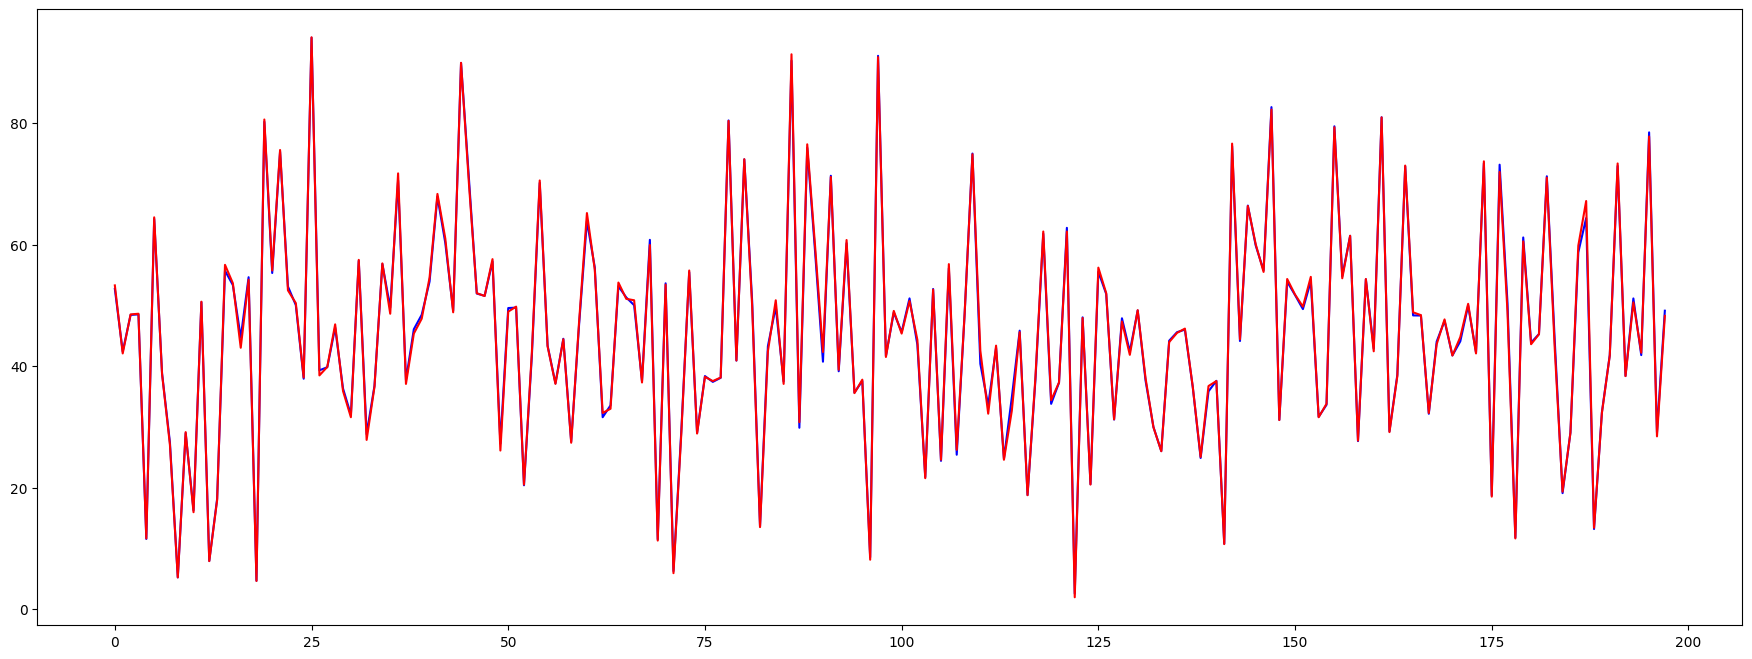

In [ ]:
#plt.plot(np.array(y_test), color = 'red', label = 'Real')
#plt.plot(ajustados_teste2_min, color = 'red', label = 'Mínimo')
#plt.plot(y_pred, color = 'blue', label = 'Previsto')

#y_test.plot(color='red',figsize=(22,8))

plt.figure(figsize=(22, 8))

plt.plot(y_pred, color = 'blue', label = 'Previsto',)
plt.plot(range(y_test.shape[0]),y_test, color = 'red', label = 'Real')


In [ ]:

#ret = retornos(df_valores)

#max = np.amax(df_valores)
#min = np.amin(df_valores)
#valores_normalizado = (df_valores-min)/(max-min)
#valores_normalizado = valores_normalizado*100+1
#print(valores_normalizado.head())
#print(np.amax(valores_normalizado))
#print(np.amin(valores_normalizado))
#print(valores_normalizado.shape)

max = np.amax(base_total)
min = np.amin(base_total)
ret_real = retornos(df_valores)
#ret_real = (((ret_real-1)/100)*(max-min))+min
vol_real = volatilidade(k=6,p=2,vetor=ret_real)
#X_real = (((X-1)/100)*(max-min))+min
y_ajustado_total = reg.predict((((base_total.iloc[:,0:5]-min)/(max-min))*100)+1)
print(y_ajustado_total.shape)

y_ajustado_total = (((y_ajustado_total-1)/100)*(max-min))+min
ret_ajustado = retornos(y_ajustado_total)
vol_ajustado = volatilidade(k=6,p=2,vetor=ret_ajustado)


(987,)


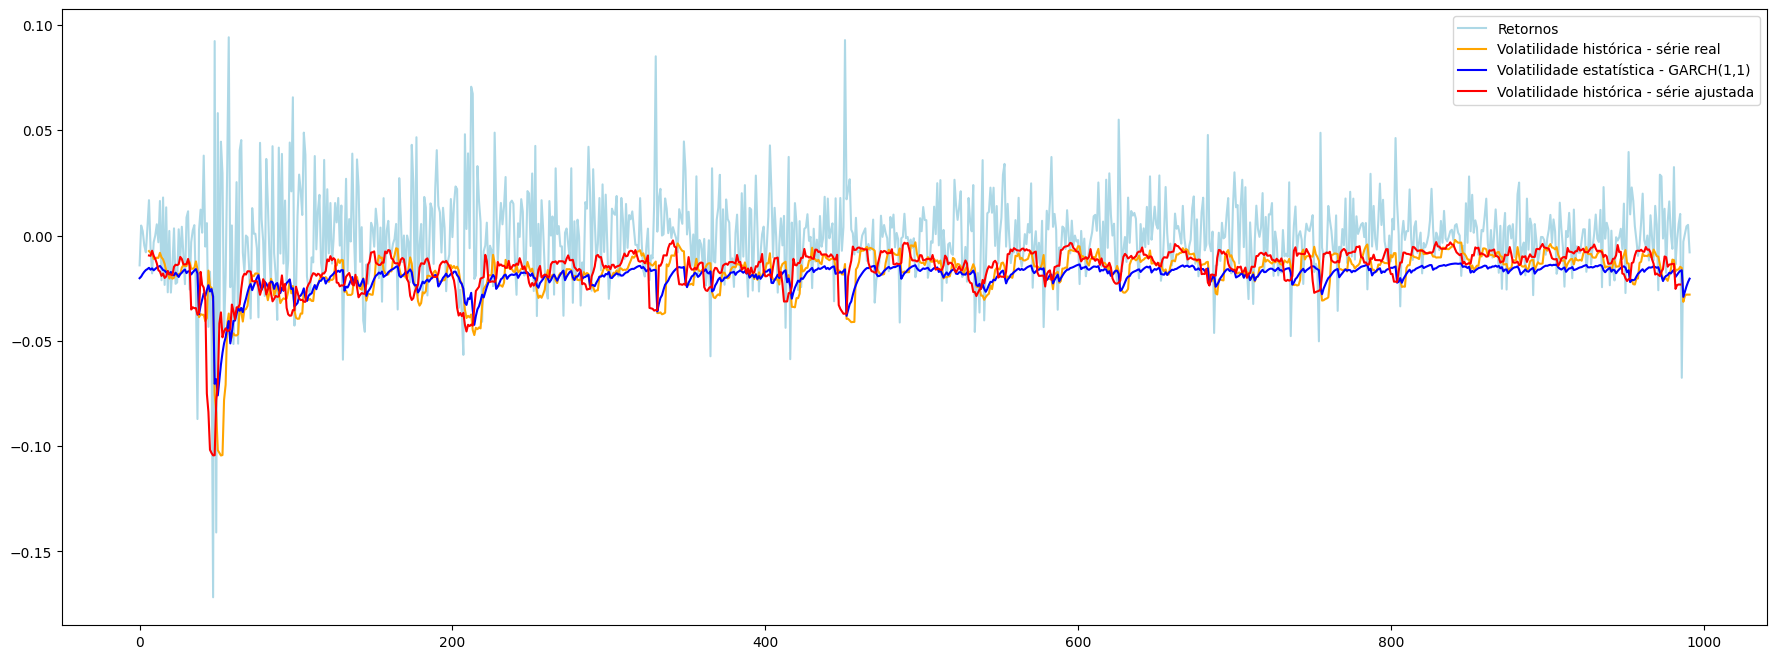

In [ ]:

plt.figure(figsize=(22, 8))

plt.plot(ret_real, color = 'lightblue', label = 'Retornos')
plt.plot(-vol_real, color = 'orange', label = 'Volatilidade histórica - série real')
plt.plot(-df_vol['x'], color = 'blue', label = 'Volatilidade estatística - GARCH(1,1)')
plt.plot(-vol_ajustado, color = 'red', label = 'Volatilidade histórica - série ajustada')
#plt.title('Série de Preços: ABEV.SA')
#plt.xlabel('Data')
#plt.ylabel('Preço de fechamento')
plt.legend()



In [ ]:
reg.get_booster()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

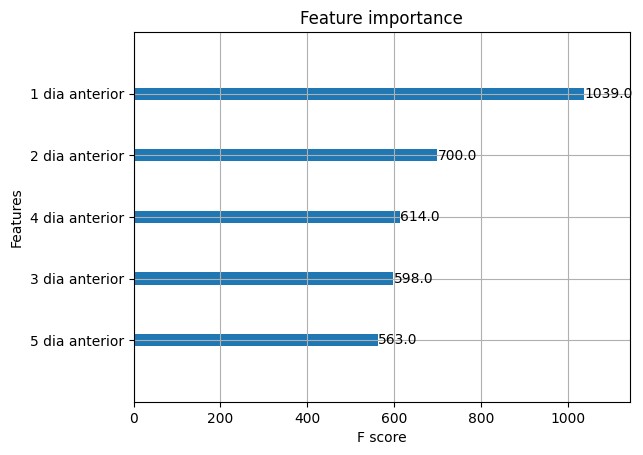

In [ ]:
xgb.plot_importance(reg)

<Axes: >

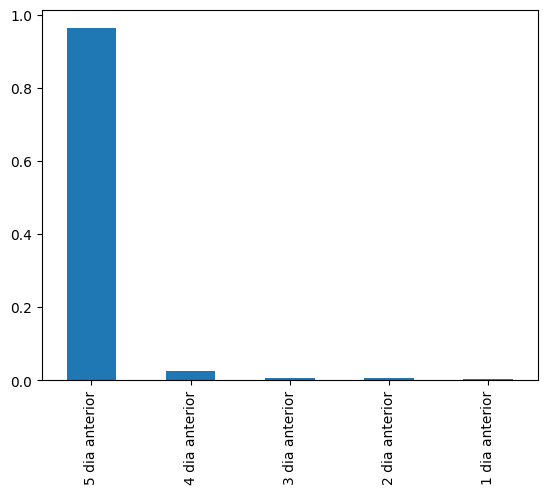

In [ ]:
importances = pd.Series(reg.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot.bar()

<Axes: >

<Figure size 2200x800 with 0 Axes>

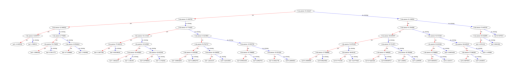

In [ ]:
plt.figure(figsize=(22, 8))
xgb.plot_tree(reg, num_trees=1)

# XGBoost - Volatilidade

In [ ]:

df_prc = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/ABEV3.SA_Volatilidade - 5dep.csv')

df_prc = df_prc.iloc[:,1:]
df_prc = df_prc.dropna()
base_total = df_prc
print(base_total.head())



         x1        x2        x3        x4        x5         y
0  0.010561  0.003668  0.003662  0.006535  0.006197  0.012165
1  0.003668  0.003662  0.006535  0.006197  0.012165  0.012553
2  0.003662  0.006535  0.006197  0.012165  0.012553  0.013334
3  0.006535  0.006197  0.012165  0.012553  0.013334  0.012901
4  0.006197  0.012165  0.012553  0.013334  0.012901  0.002265


In [ ]:
max = np.amax(base_total)
min = np.amin(base_total)
base_treinamento_normalizada = (base_total-min)/(max-min)
base_treinamento_normalizada = base_treinamento_normalizada*1000
print(base_treinamento_normalizada.head())
print(np.amax(base_treinamento_normalizada))
print(np.amin(base_treinamento_normalizada))


          x1         x2         x3         x4         x5          y
0  73.778257  23.636117  23.589199  44.494499  42.032160  85.445278
1  23.636117  23.589199  44.494499  42.032160  85.445278  88.269728
2  23.589199  44.494499  42.032160  85.445278  88.269728  93.950290
3  44.494499  42.032160  85.445278  88.269728  93.950290  90.800992
4  42.032160  85.445278  88.269728  93.950290  90.800992  13.430075
1000.0
0.0


In [ ]:
# Tirando a v. resposta da base de treinamento
# df.drop(columns='cat')
X = base_treinamento_normalizada.drop(columns=["y"
#                      ,"cat"
                    ],axis = 1).copy()
y = base_treinamento_normalizada["y"].copy()

# Tirando ID da base de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Regressão Multivariada - Valores

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
df_prc = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/ABEV3.SA_Valores - 5dep.csv')
df_vol = pd.read_csv('/content/drive/My Drive/TCC MBA/Dados/DesvioPadrao_ABEV.csv')

df_prc = df_prc.iloc[:,1:]
df_prc = df_prc.dropna()
base_total = df_prc
base_total.columns = ['1 dia anterior','2 dia anterior','3 dia anterior','4 dia anterior','5 dia anterior',"y"]
print(base_total.head())
print(df_vol.head())


   1 dia anterior  2 dia anterior  3 dia anterior  4 dia anterior  \
0       19.200001       18.930000       19.020000       19.059999   
1       18.930000       19.020000       19.059999       18.969999   
2       19.020000       19.059999       18.969999       18.820000   
3       19.059999       18.969999       18.820000       18.889999   
4       18.969999       18.820000       18.889999       19.209999   

   5 dia anterior          y  
0       18.969999  18.820000  
1       18.820000  18.889999  
2       18.889999  19.209999  
3       19.209999  19.100000  
4       19.100000  18.760000  
          x
0  0.020257
1  0.019487
2  0.018227
3  0.017194
4  0.016386


In [ ]:
max = np.amax(base_total)
min = np.amin(base_total)
base_treinamento_normalizada = (base_total-min)/(max-min)
base_treinamento_normalizada = base_treinamento_normalizada*100+1
print(base_treinamento_normalizada.head())
print(np.amax(base_treinamento_normalizada))
print(np.amin(base_treinamento_normalizada))


   1 dia anterior  2 dia anterior  3 dia anterior  4 dia anterior  \
0       96.332560       93.182030       94.232207       94.698940   
1       93.182030       94.232207       94.698940       93.648763   
2       94.232207       94.698940       93.648763       91.898476   
3       94.698940       93.648763       91.898476       92.715275   
4       93.648763       91.898476       92.715275       96.449227   

   5 dia anterior          y  
0       93.648763  91.898476  
1       91.898476  92.715275  
2       92.715275  96.449227  
3       96.449227  95.165695  
4       95.165695  91.198365  
101.0
1.0


In [ ]:
# Tirando a v. resposta da base de treinamento
# df.drop(columns='cat')
X = base_treinamento_normalizada.drop(columns=["y"
#                      ,"cat"
                    ],axis = 1).copy()
y = base_treinamento_normalizada["y"].copy()

# Tirando ID da base de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Instanciar o modelo de regressão linear múltipla
model_linear = LinearRegression()

# Treinar o modelo nos dados de treino
model_linear.fit(X_train, y_train)

# Coeficientes de regressão
print("Coeficientes de regressão:")
print(model_linear.coef_)

# Intercepto
print("Intercepto:")
print(model_linear.intercept_)

Coeficientes de regressão:
[ 0.02844307 -0.02218796 -0.10221201  0.14187822  0.93029605]
Intercepto:
1.0034711898330144


In [ ]:
# MSE
y_ajustado = model_linear.predict(X_train)
mse_clf1 = mean_absolute_percentage_error(y_train, y_ajustado)
r2_clf1 = r2_score(y_train, y_ajustado)

y_pred = model_linear.predict(X_test)
mse_clf = mean_absolute_percentage_error(y_test, y_pred)
r2_clf = r2_score(y_test, y_pred)

#print('Acurácia: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
#      .format(acc*100, auc*100, gini*100))

print(mse_clf1)
print(r2_clf1)
#print('MSE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf))
print('Treino = MAPE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf1*100, r2_clf1*100))
print(" ")

print(mse_clf)
print(r2_clf)
#print('MSE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf))
print('Teste = MAPE: {0:.2f}% \R-Squared: {1:.2f}%' .format(mse_clf*100, r2_clf*100))



0.0983474267889742
0.9681841890887238
Treino = MAPE: 9.83% \R-Squared: 96.82%
 
0.09694212537679138
0.9592911799340366
Teste = MAPE: 9.69% \R-Squared: 95.93%


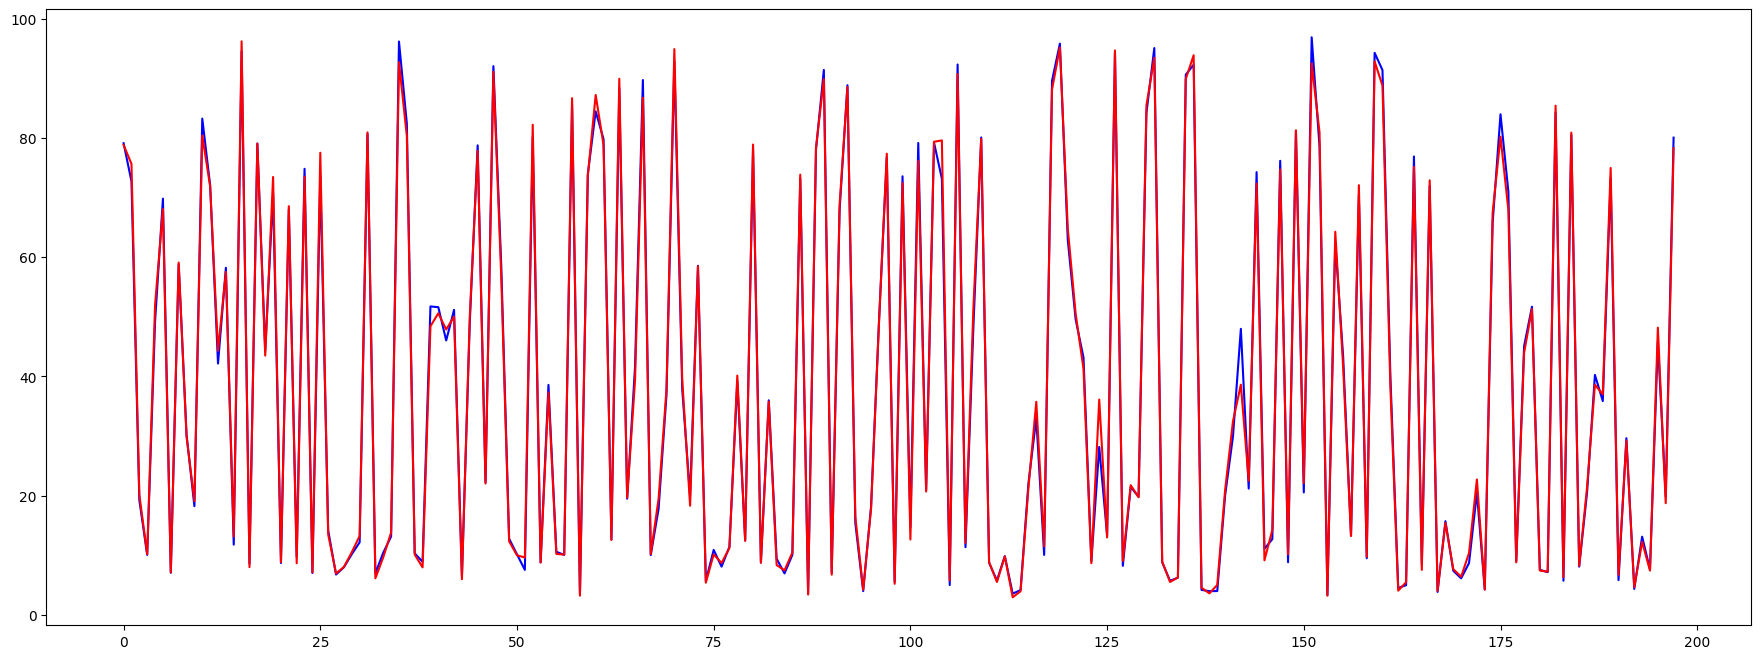

In [ ]:
#plt.plot(np.array(y_test), color = 'red', label = 'Real')
#plt.plot(ajustados_teste2_min, color = 'red', label = 'Mínimo')
#plt.plot(y_pred, color = 'blue', label = 'Previsto')

#y_test.plot(color='red',figsize=(22,8))

plt.figure(figsize=(22, 8))

plt.plot(y_pred, color = 'blue', label = 'Previsto',)
plt.plot(range(y_test.shape[0]),y_test, color = 'red', label = 'Real')


In [ ]:

#ret = retornos(df_valores)

#max = np.amax(df_valores)
#min = np.amin(df_valores)
#valores_normalizado = (df_valores-min)/(max-min)
#valores_normalizado = valores_normalizado*100+1
#print(valores_normalizado.head())
#print(np.amax(valores_normalizado))
#print(np.amin(valores_normalizado))
#print(valores_normalizado.shape)

max = np.amax(base_total)
min = np.amin(base_total)
ret_real = retornos(df_valores)
#ret_real = (((ret_real-1)/100)*(max-min))+min
vol_real = volatilidade(k=6,p=2,vetor=ret_real)
#X_real = (((X-1)/100)*(max-min))+min
y_ajustado_total = model_linear.predict((((base_total.iloc[:,0:5]-min)/(max-min))*100)+1)
print(y_ajustado_total.shape)

y_ajustado_total = (((y_ajustado_total-1)/100)*(max-min))+min
ret_ajustado = retornos(y_ajustado_total)
vol_ajustado = volatilidade(k=6,p=2,vetor=ret_ajustado)


(987,)


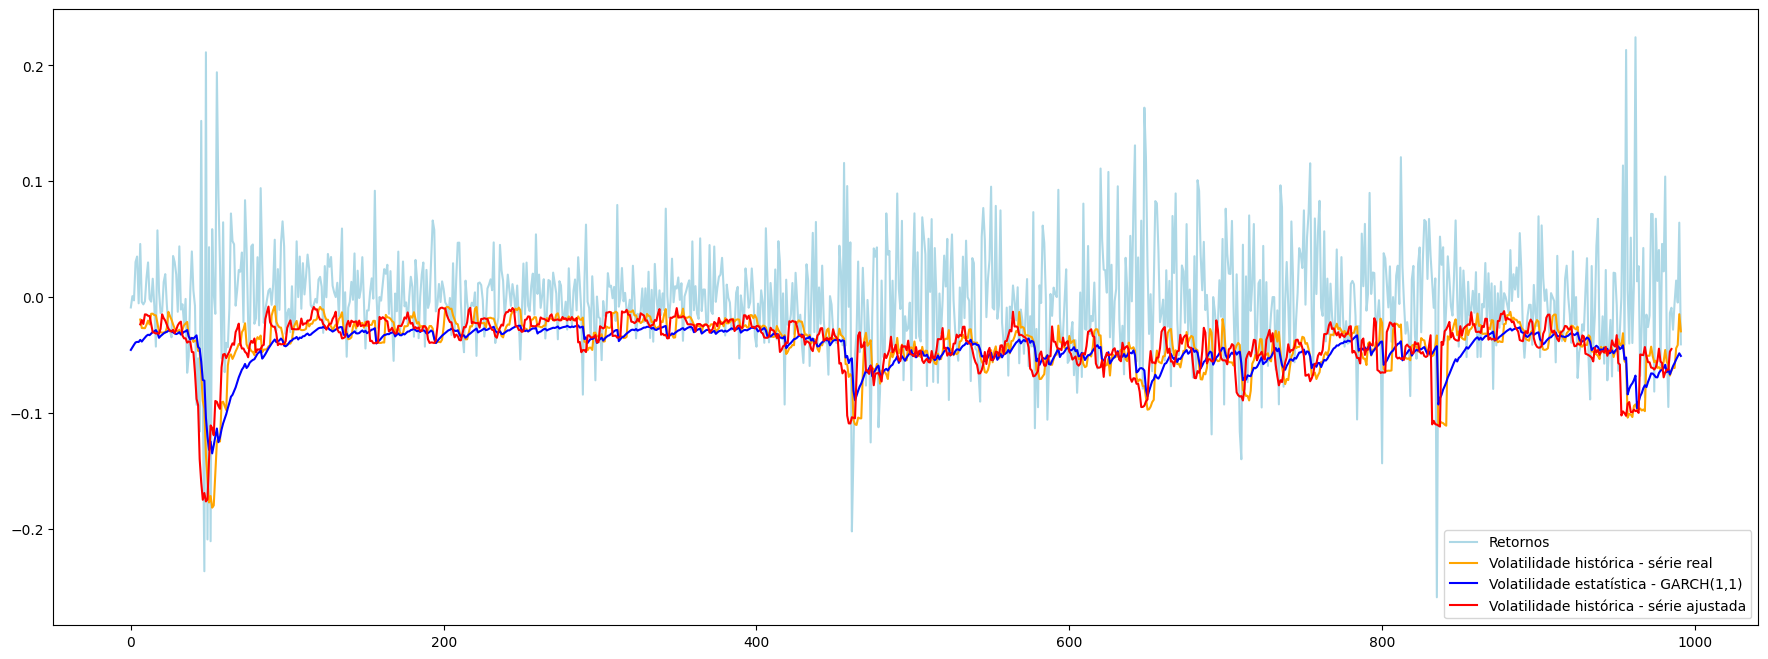

In [ ]:

plt.figure(figsize=(22, 8))

plt.plot(ret_real, color = 'lightblue', label = 'Retornos')
plt.plot(-vol_real, color = 'orange', label = 'Volatilidade histórica - série real')
plt.plot(-df_vol['x'], color = 'blue', label = 'Volatilidade estatística - GARCH(1,1)')
plt.plot(-vol_ajustado, color = 'red', label = 'Volatilidade histórica - série ajustada')
#plt.title('Série de Preços: ABEV.SA')
#plt.xlabel('Data')
#plt.ylabel('Preço de fechamento')
plt.legend()



<Axes: >

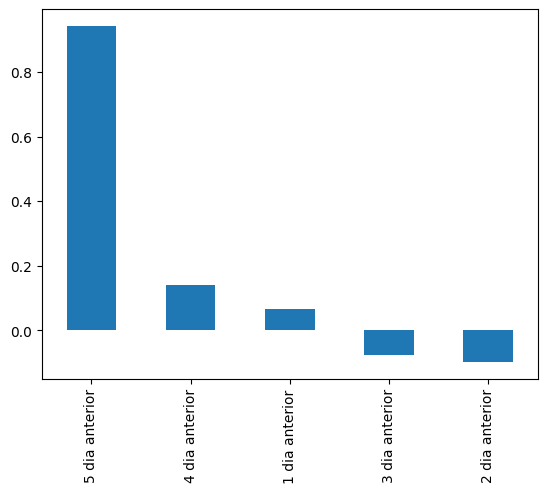

In [ ]:
importances = pd.Series(model_linear.coef_, index=X.columns)
importances.sort_values(ascending=False).plot.bar()